In [1]:
import pandas as pd
import math
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
random.seed(17)

In [2]:
response = "DEATH_FLAG"

In [3]:
Z = pd.read_excel("data_cleaned3.xlsx")
Z = Z.drop("Unnamed: 0",axis = 1)

In [4]:
Z_first = Z[response]
Z_other = Z.drop(response,axis = 1)

Z = pd.concat( [Z_first,Z_other] ,axis = 1)

In [5]:
Z

,DEATH_FLAG,AA_FLAG,CARD_FLAG,DIA_FLAG,FEM_FLAG,ALZ_FLAG,CANCER_FLAG,BMI >30_N,BMI >30_Y,Sex_Female,...,"Aortic_Bio_Age_[51.6,53.2)","Aortic_Bio_Age_[53.2,55.5)","Aortic_Bio_Age_[55.5,57.6)","Aortic_Bio_Age_[57.6,60.8)","Liver_Bio_Age_[67.8,50.1)","Liver_Bio_Age_[50.1,53.4)","Liver_Bio_Age_[53.4,55.0)","Liver_Bio_Age_[55.0,56.2)","Liver_Bio_Age_[56.2,57.3)","Liver_Bio_Age_[57.3,58.7)"
0,1,0,1,0,0,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,1,1,0,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8259,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
8260,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
8261,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
8262,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def H(Z, j):
    K = [0, 1]
    v = 0
    for k in K:
        P = len(Z[j][Z[j] == k]) / len(Z)
        if P != 0:
            v += P * math.log(1 / P, 2)
    return v


def mut_info(Z, j):
    K = [0, 1]  # this is the possible values for the x_j
    L = [0, 1]  # This is the possible values for the resposonse
    t1 = H(Z, j)
    t2 = 0
    for l in L:
        P = len(Z[response][Z[response] == l]) / len(Z)
        t2 += P * H(Z[Z[response] == l], j)
    return t1 - t2

In [7]:
def find_best_split(Z):
    best_I = -10000
    best_j = ""
    for j in Z.columns[1:(len(Z.columns))]:
        #print(j)
        try:
            if mut_info(Z, j) > best_I:
                best_I = mut_info(Z, j)
                best_j = j
        except:
            0
    return best_j, best_I


In [8]:
find_best_split(Z)

('CARD_FLAG', 0.03495559074251775)

In [9]:
def prune_the_tree(X,Y,L,T,Terminals): # This cleans up the final tree print out
    parent = "0"
    nodes = ["0"]
    children = {}
    parent = {}
    keep_going = True
    for n in nodes:
        if n in Terminals:
            0
        else:
            keep_going = True
            nodes.append(n+"1")
            nodes.append(n+"0")
            parent[n+"1"] = []
            parent[n+"1"].append(n) 
            parent[n+"0"] = []
            parent[n+"0"].append(n) 
            children[n] = []
            children[n].append(n+"1")
            children[n].append(n+"0")
    parent[0] = []
    for n in reversed(nodes):
        try:
            for nn in parent[n]:
                children[nn] += children[n]
        except:
            0 
    for n in reversed(nodes):
        try:
            if (children[n][0] in Terminals) & (T[children[n][0]] == T[children[n][1]]):
                T[n] = T[children[n][0]]
                Terminals.append(n)
                L.remove([X[n],X[children[n][0]],Y[n],Y[children[n][0]],"red"])
                L.remove([X[n],X[children[n][1]],Y[n],Y[children[n][1]],"blue"])
                X.pop(children[n][0])
                Y.pop(children[n][0])
                T.pop(children[n][0])
                X.pop(children[n][1])
                Y.pop(children[n][1])
                T.pop(children[n][1])
        except:
            0
    return X,Y,L,T,Terminals


In [10]:
def create_tree(train_data, test_data,max_d):
    Samples = {}  # Sample for each node
    Split_By = {}  # Sample for each node
    Nodes = {}  # Each node contains a level and a number
    X = {}
    Y = {}
    Text = {}
    Terminals = []
    Lines = []

    Nodes["0"] = ""  # This is so we can understand the found tree
    Z["Predict"] = -1  # This is where we store the prediction
    Samples["0", "train"] = train_data
    Samples["0", "test"] = test_data
    Active = ["0"]
    Y['0'] = 0
    X['0'] = 0
    Active_new = []
    
    depth = 0
    while len(Active) > 0:  # Keep running until no more actice nodes
        depth += 1
        for pp in Active:
            #For each active node, we create two branches
            Active_new.append(str(pp + "0"))
            Active_new.append(str(pp + "1"))

            # We then find the feature with the highest mutual info
            # Note! only use train data
            split_j, best_I = find_best_split(Samples[pp, "train"])

            # Then split on best feature
            Samples[str(pp + "1"), "train"] = Samples[pp, "train"].loc[Samples[
                pp, "train"][split_j] == 1].drop(split_j, axis=1)
            Samples[str(pp + "0"), "train"] = Samples[pp, "train"].loc[Samples[
                pp, "train"][split_j] == 0].drop(split_j, axis=1)
            Samples[str(pp + "1"), "test"] = Samples[pp, "test"].loc[Samples[
                pp, "test"][split_j] == 1]
            Samples[str(pp + "0"), "test"] = Samples[pp, "test"].loc[Samples[
                pp, "test"][split_j] == 0]

            # This is so we can understand the found tree
            Nodes[str(pp + "1")] = Nodes[pp] + " (X.loc[i,\"" + str(
                split_j) + "\"] == 1) &"
            Nodes[str(pp + "0")] = Nodes[pp] + " (X.loc[i,\"" + str(
                split_j) + "\"] == 0) &"

            # This is to print the tree
            Y[str(pp + "1")] = Y[str(pp)] - 1
            Y[str(pp + "0")] = Y[str(pp)] - 1
            X[str(pp + "0")] = X[str(pp)] + 2**max(Y[str(pp)], -3) / 4
            X[str(pp + "1")] = X[str(pp)] - 2**max(Y[str(pp)], -3) / 4
            Lines.append([
                X[str(pp)], X[str(pp + "1")], Y[str(pp)], Y[str(pp + "1")],
                "red"
            ])
            Lines.append([
                X[str(pp)], X[str(pp + "0")], Y[str(pp)], Y[str(pp + "0")],
                "blue"
            ])

            Text[str(pp)] = str(split_j)

        Active = []

        for pp in Active_new:
            split_j, best_I = find_best_split(Samples[pp, "train"])

            # THIS IS OUR STOPPING CRITERIA
            if (len(Samples[pp, "train"]) <= 5
                ) | (depth >= max_d) | (best_I < -1):  # Stopping Criteria

                if sum(Samples[pp, "train"][response] == 1) > sum(
                        Samples[pp, "train"][response] == 0):

                    # This is so we can implemnet the found tree
                    Nodes[pp] = Nodes[pp][0:(
                        len(Nodes[pp]) -
                        2)] + ":\\\\ \n    X.loc[i,\"Predict\"] = 1"
                    Text[str(pp)] = "Predict\n = 1"
                    Terminals.append(pp)

                    # This is where we use found prediction on test data
                    Samples[pp, "test"].loc[:, "Predict"] = 1

                else:
                    Nodes[pp] = Nodes[pp][0:(
                        len(Nodes[pp]) -
                        2)] + ":\\\\ \n    X.loc[i,\"Predict\"] = 0"
                    Text[str(pp)] = "Predict\n = 0"
                    Terminals.append(pp)

                    # This is where we use found prediction on test data
                    Samples[pp, "test"].loc[:, "Predict"] = 0

            # IF WE DON'T STOP
            else:
                Active.append(pp)
        Active_new = []

    test = Samples[Terminals[0], "test"]
    for i in range(1, len(Terminals)):
        test = pd.concat([test, Samples[Terminals[i], "test"]])
        
        
    X,Y,Lines,Text,Terminals = prune_the_tree(X,Y,Lines,Text,Terminals) # This cleans up the objects used for printing the tree
    return test, Nodes, Terminals, X, Y, Text, Lines


In [11]:
def print_tree(X, Y, T, L, title):
    plt.rcParams.update({'font.size': 15})
    xs = []
    ys = []
    color = []
    txt = []
    # Make lists for priting
    for i in X:
        xs.append(X[i])
        ys.append(Y[i])
        if T[i] == "Predict\n = 1":
            color.append("lightgreen")
        elif T[i] == "Predict\n = 0":
            color.append("salmon")
        else:
            color.append("lightblue")
        txt.append(T[i])

    plt.figure(figsize=(20, 10))
    plt.title(title)
    # Create legend
    plt.plot([0, 0], [0, 0], color="blue", label="Feature = 0", zorder=1)
    plt.plot([0, 0], [0, 0], color="red", label="Feature = 1", zorder=1)
    for l in L:
        #Plot lines
        plt.plot([l[0], l[1]], [l[2], l[3]], color=l[4], zorder=1)

    # Plot blocks
    plt.scatter(xs, ys, color=color, s=1000, marker=",", zorder=2)
    for i in range(0, len(xs)):
        #Plot text
        plt.text(xs[i], ys[i], txt[i], ha="center", va="center")

    plt.legend()
    plt.axis('off')
    plt.savefig(title + '.pdf', bbox_inches='tight', dpi=150)
    
    

In [12]:
def print_tree(X, Y, T, L, title):
    plt.rcParams.update({'font.size': 15})
    xs = []
    ys = []
    color = []
    txt = []
    # Make lists for priting
    for i in X:
        xs.append(X[i])
        ys.append(Y[i])
        if T[i] == "Predict\n = 1":
            color.append("lightgreen")
        elif T[i] == "Predict\n = 0":
            color.append("salmon")
        else:
            color.append("lightblue")
        txt.append(T[i])

    plt.figure(figsize=(20, 10))
    plt.title(title)
    # Create legend
    plt.plot([0, 0], [0, 0], color="blue", label="Feature = 0", zorder=1)
    plt.plot([0, 0], [0, 0], color="red", label="Feature = 1", zorder=1)
    for l in L:
        #Plot lines
        plt.plot([l[0], l[1]], [l[2], l[3]], color=l[4], zorder=1)

    # Plot blocks
    plt.scatter(xs, ys, color=color, s=1000, marker=",", zorder=2)
    for i in range(0, len(xs)):
        #Plot text
        plt.text(xs[i], ys[i], txt[i], ha="center", va="center")

    plt.legend()
    plt.axis('off')
    plt.savefig(title + '.pdf', bbox_inches='tight', dpi=150)
    
    

In [13]:
response = "DEATH_FLAG"  # This is the name of the column with the response

test, Nodes, Terminals, X, Y, T, L = create_tree(Z, Z,5)

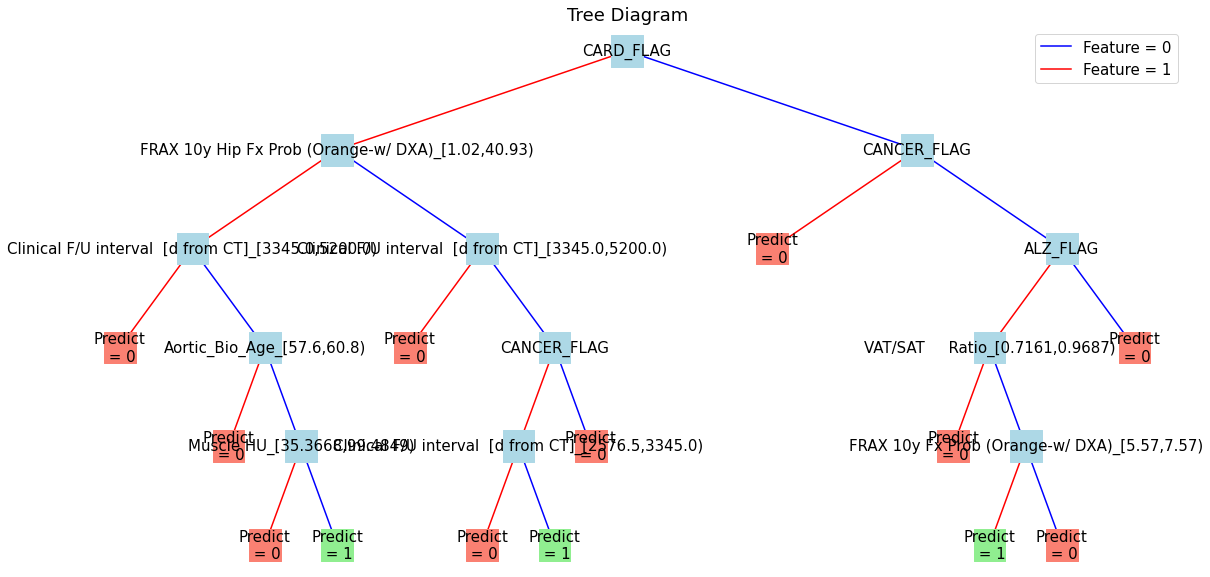

In [14]:
print_tree(X, Y, T, L, "Tree Diagram")

In [15]:
def five_fold_set_up(Z):
    Z["Fold"] = -1
    # Split Based on Response (this is to make sure the survives are approx, equal between groups)
    Sur = Z[Z[response] == 1]
    Per = Z[Z[response] == 0]
    # Randomize the Data
    Sur = Sur.sample(frac=1).reset_index(drop=True)
    Per = Per.sample(frac=1).reset_index(drop=True)
    # Assign Fold
    for i in range(len(Sur)):
        Sur.loc[i, "Fold"] = math.floor((i / len(Sur)) * 5)
    for i in range(len(Per)):
        Per.loc[i, "Fold"] = math.floor((i / len(Per)) * 5)
    # Recombine Data Sets
    Z = pd.concat([Sur, Per])
    Z = Z.reset_index(drop=True)

    return Z


In [16]:
random.seed(195)
Z = five_fold_set_up(Z)


In [17]:
def compare_depths(D):
    acc = []
    tp = []
    fp = []
    tn = [] 
    fn = []

    for f in range(0, 5):
        print("Fold Number: ", f)

        train = Z[Z["Fold"] != f].copy()
        train = train.drop("Fold", axis=1)

        test_data = Z[Z["Fold"] == f].copy()

        test, Nodes, Terminals, X, Y, T, L = create_tree(train, test_data,D)
        correct = 0
        tps = 0
        fps = 0
        tns = 0 
        fns = 0
        for i in list(test_data.index):
            if (test.loc[i, "Predict"] == test.loc[i, response]):
                correct += 1
                if (test.loc[i, "Predict"] == 1) & (test.loc[i, response] ==1):
                    tps += 1
                else:
                    tns += 1
            else:
                if (test.loc[i, "Predict"] == 0) & (test.loc[i, response] ==1):
                    fps += 1
                else:
                    fns += 1


        print("Percent Correct: ", 100 * correct / len(test))
        acc.append(100 * correct / len(test))
        tp.append(tps)
        fp.append(fps)
        tn.append(tns)
        fn.append(fns)
    print("")
    print("Accuracy Summary")
    print("Min: ", min(acc))
    print("Avg: ", sum(acc) / len(acc))
    print("Max: ", max(acc))
    print("STD: ", np.std(acc))

    return acc,tp,fp,tn,fn



In [ ]:
accuracy = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []
for i in range(5,11):
    acc,tp,fp,tn,fn = compare_depths(i)
    
    accuracy.append(acc)
    true_pos.append(tp)
    true_neg.append(tn)
    false_pos.append(fp)
    false_neg.append(fn)
    
    
    

Fold Number:  0
Percent Correct:  94.37726723095525
Fold Number:  1
Percent Correct:  94.55535390199637
Fold Number:  2
Percent Correct:  94.37046004842615
Fold Number:  3
Percent Correct:  94.49485783424078
Fold Number:  4
Percent Correct:  94.55205811138015

Accuracy Summary
Min:  94.37046004842615
Avg:  94.46999942539973
Max:  94.55535390199637
STD:  0.08141781446932056
Fold Number:  0
Percent Correct:  93.53083434099153
Fold Number:  1
Percent Correct:  94.25287356321839
Fold Number:  2
Percent Correct:  93.64406779661017
Fold Number:  3
Percent Correct:  94.61584996975196
Fold Number:  4
Percent Correct:  94.43099273607749

Accuracy Summary
Min:  93.53083434099153
Avg:  94.0949236813299
Max:  94.61584996975196
STD:  0.43144468599960556
Fold Number:  0
Percent Correct:  93.2285368802902
Fold Number:  1
Percent Correct:  93.58741681790684
Fold Number:  2
